In [509]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yaml
import io
import math
import qgrid
from sympy.solvers import solve
from sympy import Symbol
z = Symbol('x')
from scipy.optimize import curve_fit

In [561]:
initimport = pd.read_csv('inputdata.csv',header = None)

In [562]:
initimport.columns = ['x','y']

In [563]:
nums = list(initimport.loc[initimport['x'] == 0].index)

In [564]:
nums.insert(0,0)

In [565]:
fullrange = [t[1] for t in zip(nums, nums[1:]) if t[0]+1 != t[1]]

In [566]:
fullrange.insert(0,0)

In [567]:
fullranges = [list(t) for t in zip(fullrange, fullrange[1:]) ]

In [568]:
print(fullranges)

[[0, 340], [340, 776], [776, 1152], [1152, 1598], [1598, 1926], [1926, 2341], [2341, 2637]]


In [569]:
ranges = [list(t) for t in zip(nums, nums[1:]) if t[0]+1 != t[1]]

In [570]:
print(ranges)

[[0, 340], [399, 776], [799, 1152], [1199, 1598], [1599, 1926], [1999, 2341], [2399, 2637]]


In [12]:
def importrules(filename):
    with open(filename, 'r') as stream:
        data_loaded = yaml.safe_load(stream)
    indicators = pd.DataFrame(data_loaded['rules']).T
    return indicators

In [13]:
indicators = importrules("data.yaml")

In [14]:
indicators

,action binary,action value,name
0,1,"lambda x,y: sum(x)",test
1,0,"lambda x,y: sum(y)",test1
2,1,"lambda x,y: sum(x) + sum(y)",test2


In [574]:
#lets create a trials class which is just a dict that can store stuff like dataframes
class maketrial(dict):
#     def __init__(self, df):
#         #print("go")
#         self['raw'] = df
#         #print(self['raw'])
    def add(self,attr,val):
        self[attr] = val

class maketrials(dict):
    def __init__(self, filename):
        initimport = pd.read_csv(filename,header = None)
        initimport.columns = ['x','y']
        nums = list(initimport.loc[initimport['x'] == 0].index)
        nums.insert(0,0)
        fullrange = [t[1] for t in zip(nums, nums[1:]) if t[0]+1 != t[1]]
        fullrange.insert(0,0)
        fullranges = [list(t) for t in zip(fullrange, fullrange[1:])]
        print(fullranges)
        ranges = [list(t) for t in zip(nums, nums[1:]) if t[0]+1 != t[1]]
        print(ranges)
        ite = 0
        for i in range(len(ranges)):
            rangeiq = ranges[i]
            fullrangeiq = fullranges[i]
            ite += 1
            nozero = initimport.iloc[rangeiq[0]+1:rangeiq[1]-1]
            zero = initimport.iloc[fullrangeiq[0]+1:fullrangeiq[1]-1]
            self[f"{ite}"] = maketrial()
            self[f"{ite}"].add('raw',nozero)
            self[f"{ite}"].add('rawz',zero)
#         for rangeiq in ranges:
#             ite += 1
#             toplt = initimport.iloc[rangeiq[0]+1:rangeiq[1]]
#             self[f"{ite}"] = maketrial(toplt)
    def plot(self):
        for item in self.keys():
            toplt = self[item]['raw']
            plt.plot(toplt['x'],toplt['y'])
            axes = plt.gca()
            axes.set_xlim([0,1500])
            axes.set_ylim([0,500])
        plt.show()



In [575]:
def evalrules(trials,indicators):
    for item in trials.keys():
    
        trial = trials[item]['raw']
        #print(trial['x'])
        leng = len(indicators)
        initalarray = np.zeros(leng)
        for i in range(leng):
            func = eval(indicators.loc[indicators.index[i]]['action value'])
            if indicators.loc[indicators.index[i]]['action binary']:
                initalarray[i] = func(trial['x'],trial['y'])
        trials[item]['vec'] = initalarray
    return trials

In [576]:
trials = maketrials('trainingdatafinal.csv')
#trials = maketrials('inputdata.csv')

[[0, 123], [123, 536], [536, 912], [912, 1310], [1310, 1726], [1726, 2119], [2119, 2518], [2518, 3011], [3011, 3393], [3393, 3767], [3767, 4202], [4202, 4555], [4555, 4959], [4959, 5331], [5331, 5819], [5819, 6141], [6141, 6544], [6544, 7086], [7086, 7427], [7427, 7760], [7760, 8235], [8235, 8637], [8637, 8989], [8989, 9395], [9395, 9772], [9772, 10172], [10172, 10592], [10592, 11099], [11099, 11419], [11419, 11841], [11841, 12227], [12227, 12607], [12607, 13011], [13011, 13412], [13412, 13822], [13822, 14177], [14177, 14575], [14575, 15006], [15006, 15389], [15389, 15815]]
[[0, 123], [399, 536], [799, 912], [1199, 1310], [1599, 1726], [1999, 2119], [2399, 2518], [2799, 3011], [3199, 3393], [3599, 3767], [3999, 4202], [4399, 4555], [4799, 4959], [5199, 5331], [5599, 5819], [5999, 6141], [6399, 6544], [6799, 7086], [7199, 7427], [7599, 7760], [7999, 8235], [8399, 8637], [8799, 8989], [9199, 9395], [9599, 9772], [9999, 10172], [10399, 10592], [10799, 11099], [11199, 11419], [11599, 11841

In [577]:
trials = evalrules(trials,indicators)

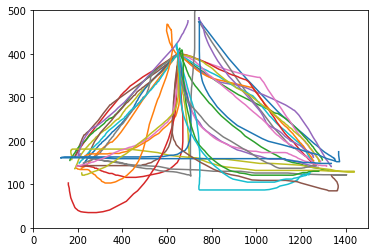

In [578]:
trials.plot()

In [583]:
def plotwithperp(trial):
    fx = trial['raw']['x'].iloc[0]
    lx = trial['raw']['x'].iloc[-1]
    fy = trial['raw']['y'].iloc[0]
    ly = trial['raw']['y'].iloc[-1]
    slope = (float(fy) - ly) / float(fx - lx)
    bee = fy - (slope*fx)
    func = lambda x: (slope * x) + bee
    gety = lambda x: trial['raw'].loc[trial['raw']['x'] == x]['y'].iloc[0]
    r = list(trial['raw']['x'].to_dict().values())
    perpslope = - ((1)/float(slope))
    perpbee = lambda x,y: y - (perpslope*x)
    perpintersect = lambda x: solve(( (perpslope * z) + perpbee(x,gety(x)) - ((slope * z) + bee)), z) #fix final gety(x) term
    
    #now we just need to determine ymax
    maxdist = 0.0
    maxp1 = [0,0]
    maxp2 = [0,0]
    for i in r[1:-1]:   
        perpx = perpintersect(i)
        perpx = perpx[0]
        test = ((i - perpx)**2 + (gety(i) - func(perpx))**2)
        dist = math.sqrt(test))
        if dist > maxdist:
            maxdist = dist
            maxp1 = [i, gety(i)]
            maxp2 = [perpx, func(perpx)]
    print(maxdist)
    x = trial['raw']['x']
    y = trial['raw']['y']
    plt.plot(x,y,'b')
    plt.plot([maxp1[0],maxp2[0]],[maxp1[1],maxp2[1]],'r')
    plt.plot(r,[func(i) for i in r],'g')
    plt.show()

In [584]:
#trial = trials['5']

19.93924730370479


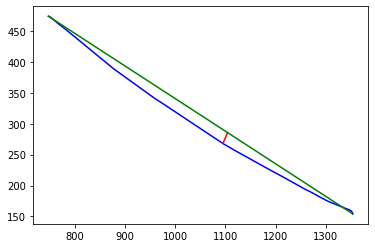

21.682103591528474


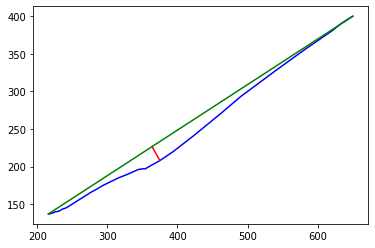

30.923413955099363


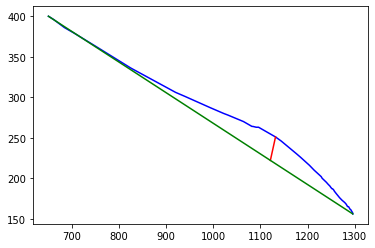

32.38981282540697


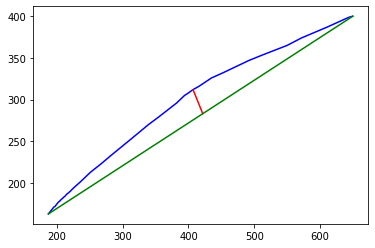

62.40448383458571


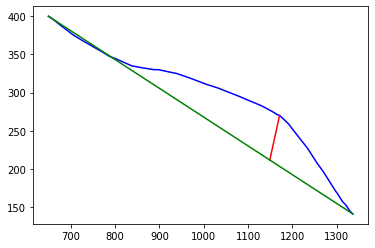

35.110747584191685


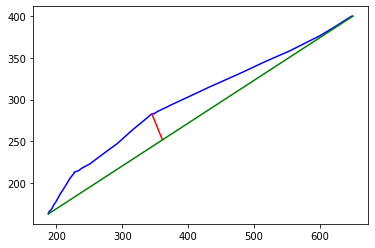

82.27251168994667


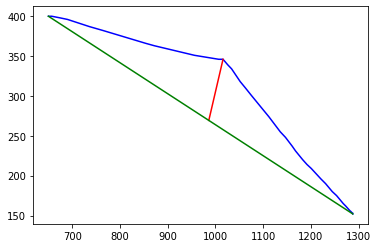

25.26108287628293


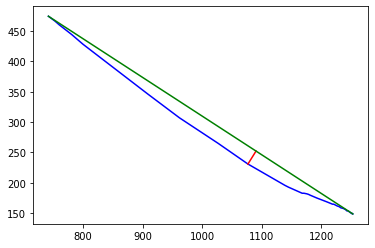

16.450976334478128


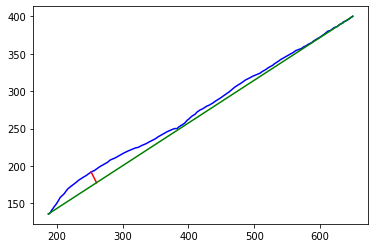

39.527658457277795


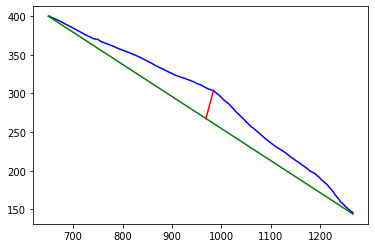

9.157141541067844


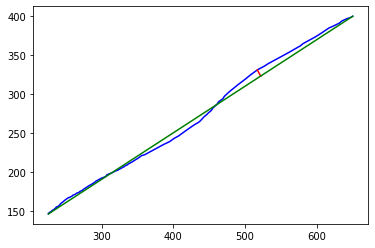

53.160969372053


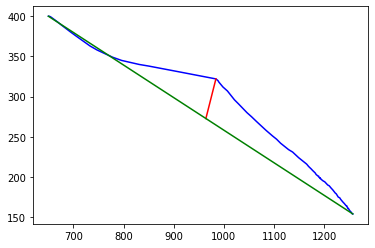

13.526716437418342


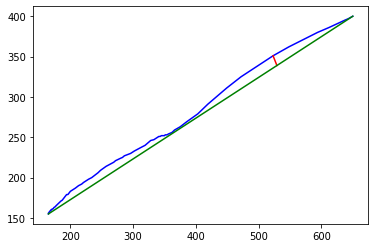

63.10150584531379


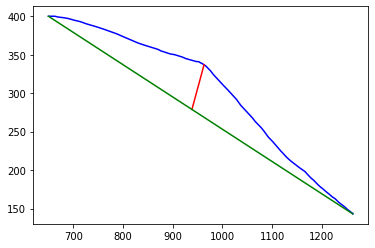

43.332648187197385


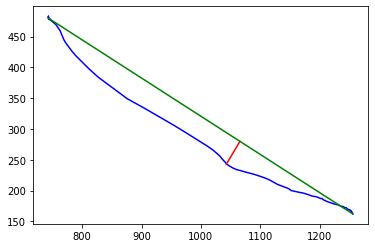

15.624610439800804


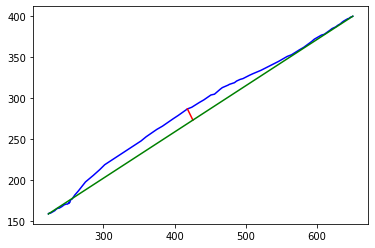

13.45794195997877


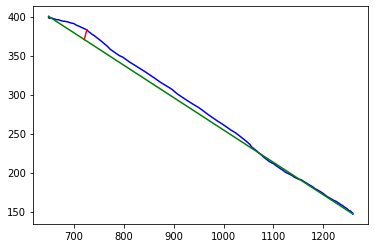

19.384074701542854


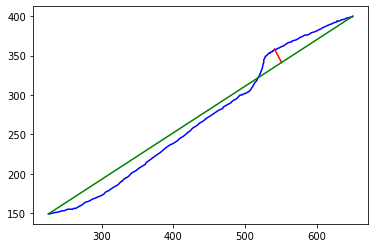

29.163881487076065


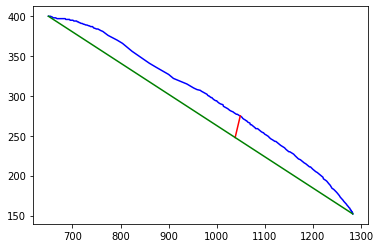

12.88774230186744


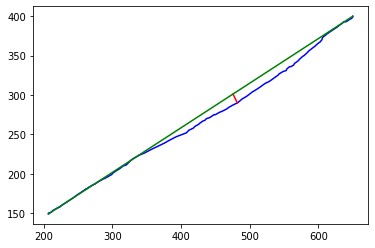

143.59623414817833


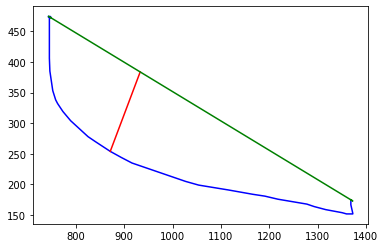

120.97579518638139


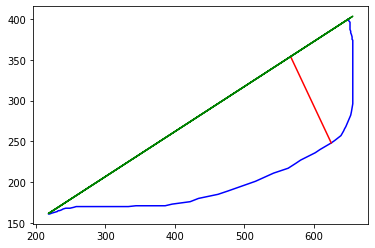

64.95635882033741


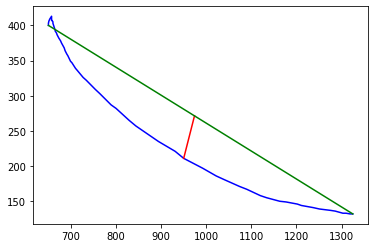

214.52263912911891


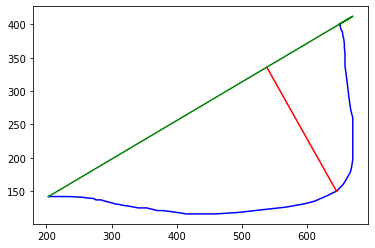

114.98572221017325


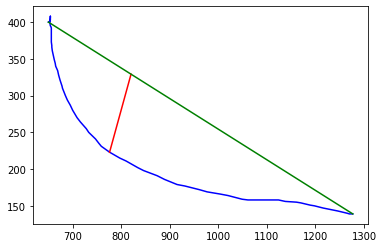

166.8644164771324


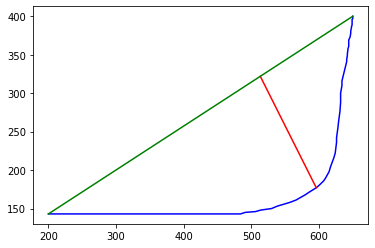

121.6986864899655


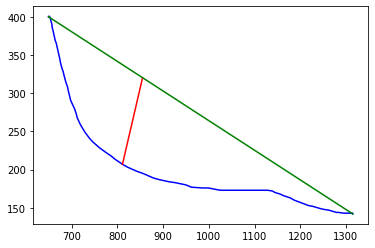

541.3843109054604


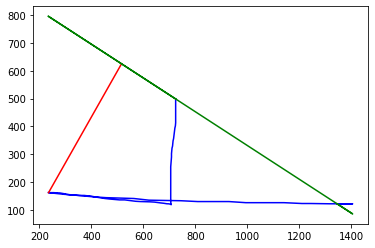

600.0562589038069


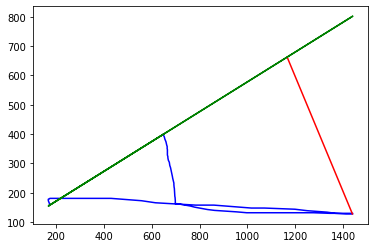

238.06415926958798


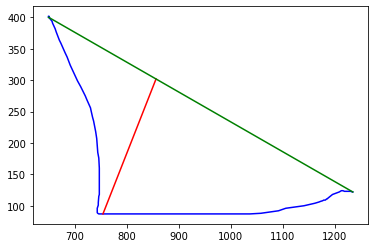

405.71605789397535


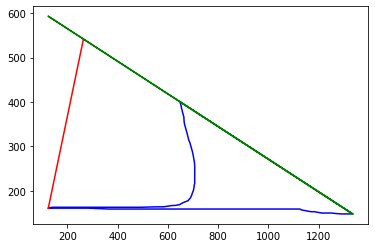

129.20765306034139


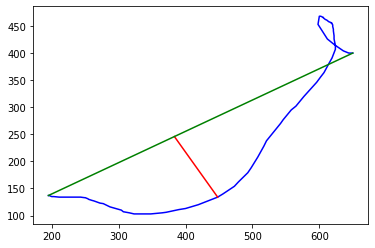

162.2947510146171


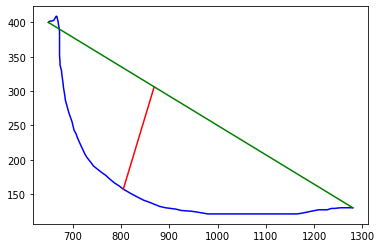

176.05026267714337


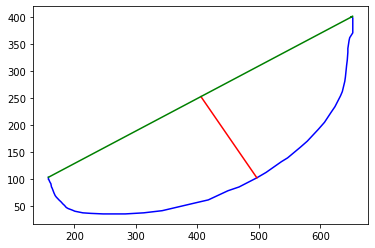

22.519404494845705


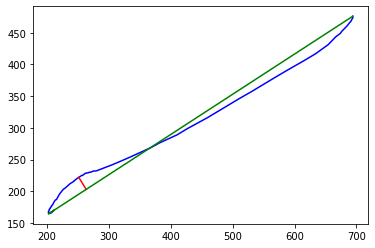

198.8573214120707


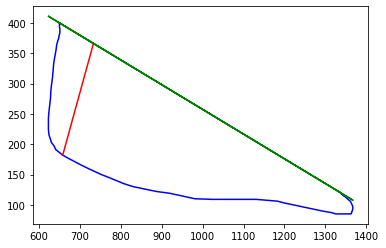

112.89584033320705


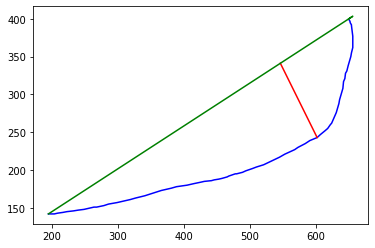

99.90171168033369


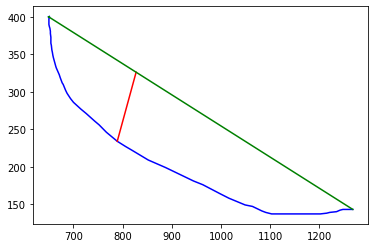

103.7636921000899


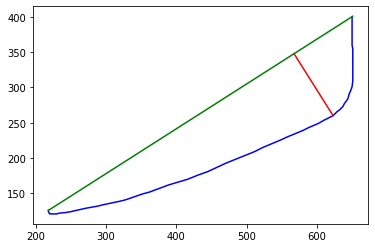

165.1773986708505


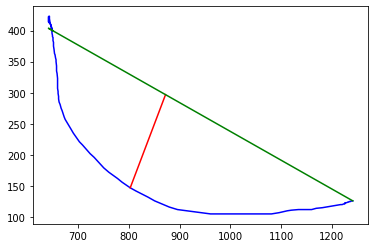

In [585]:
for i in trials.keys():
    #print(i)
    plotwithperp(trials[i])

In [586]:
print('YEEEHAW')

YEEEHAW
